# SCHEMA ALIGNMENT: REMATCH

### (1) PRE-PROCESSING AND READING OF SOURCE DATASETS

In [1]:
import os
import json
import pandas as pd

In [2]:
'''
A function that takes as input the path to a directory containing several csv files and an integer 'v'
and returns a dictionary of dictionaries that stores each field and 'v' sample values for each table
'''
def read_tables_from_folder(folder, v):
    data = {}
    file_list = os.listdir(folder)
    
    for file in file_list:
        if file.endswith(".csv"):
            table_name = os.path.splitext(file)[0]
            file_path = os.path.join(folder, file)
            
            # Read the CSV file using pandas
            try:
                df = pd.read_csv(file_path)
            except pd.errors.EmptyDataError:
                print(f"Error: File '{file}' is empty.")
                continue
            
            # Extract attributes and 3 non-NaN values for each attribute
            attributes = {}
            for column in df.columns:
                # Skip NaN values and take the first 3 non-NaN values
                sample_values = df[column].dropna().head(v).tolist()
                attributes[column] = sample_values
            
            # Add to the main dictionary
            data[table_name] = attributes
    
    return data

In [3]:
folder_with_csv = "./sources"
result = read_tables_from_folder(folder_with_csv, 3)

# Print the result
for table, attributes in result.items():
    print(f"Table: {table}")
    for attribute, values in attributes.items():
        print(f"  Attribute: {attribute}")
        print(f"    Sample values: {values}")

Table: FR-sole24ore
  Attribute: Address
    Sample values: ['Via Damiano Chiesa 53', 'Piazza IV Novembre 4', 'Piazza Manifattura 1']
  Attribute: Country
    Sample values: ['Bitritto', 'Milano', 'Rovereto']
  Attribute: Category
    Sample values: ['Servizi generali', "Vendita al dettaglio & all'ingrosso", 'Energia']
  Attribute: 7.337
    Sample values: [8.375, 13.889, 3.585]
  Attribute: Name
    Sample values: ['Pegaso Security S.r.l.', 'Euro Top Brand S.r.l.s.', 'Infinityhub S.p.A. Benefit']
Table: DeBiGa-globaldata
  Attribute: name
    Sample values: ['US Ecology Inc', 'Mercury Systems Inc', 'Xiwang Foodstuffs Co Ltd']
  Attribute: headquarters
    Sample values: ['United States of America', 'United States of America', 'China']
  Attribute: number_of_employees
    Sample values: ['3,600', '2,386', '1,892']
  Attribute: address
    Sample values: ['101 S Capitol Blvd Ste 1000, Boise, Idaho, 83702', '50 Minuteman Drive, Andover, Massachusetts, 01810', 'Xiwang Industrial Park, Zou

In [45]:
'''
This function stores a dictionary on a json file:
store the dictionary returned by the read_tables_from_folder function 
'''
def save_attributes_to_json(attributes, output_file):
    # Writes the attribute dictionary to a JSON file
    with open(output_file, 'w', encoding='utf-8') as file:
        json.dump(attributes, file, ensure_ascii=False, indent=4)


In [22]:
save_attributes_to_json(result, "attributes_per_source.json")

### (2) GENERATION OF SOURCE TABLE ATTRIBUTE DESCRIPTIONS VIA LLM

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from groq import Groq

In [20]:
# !! export GROQ_API_KEY="your_key"
api_key = os.getenv("GROQ_API_KEY")
chat = ChatGroq(temperature=0, groq_api_key=api_key, model_name="llama3-8b-8192")

In [29]:
'''
This function asks llm on the basis of the name and a few example values of each attribute to
generate a short description
'''
def generate_descriptions():
    response_dict = {}
    for source, attributes in result.items():
        attributes_string = str(attributes)
        # Template 
        template = """You are an assistant who must help me to analyse the fields of a table.
            Here are the fields of the table each with 3 example values: {table}
            Based only on the values of each field, you have to give us a description in natural language of up to 7 words for each field. 
            All I want to output is a list of tuples Python like this:
            [(field title1,description1),
            (field title2,description2)]. 
            You have to return only the list of tuples without any messages.
            If one field is empty, not return the description for this field"""
        
        # Create prompt for the llm using the template
        prompt = ChatPromptTemplate.from_messages([("human", template)])
        chain = prompt | chat
        response = chain.invoke({"table": attributes_string})
        response_dict[source] = response.content
    return response_dict

In [30]:
attributes_descriptions = generate_descriptions()
print(attributes_descriptions)

{'avengers-hitHorizons': "I'd be happy to help you with that. After analyzing the fields, here is the list of tuples with descriptions:\n\n[('id', 'Unique identifier for each record'), \n('name', 'Company name'), \n('address', 'Physical location of the company'), \n('nation', 'Country code'), \n('hhid', 'Unique identifier for household'), \n('industry', 'Type of business or sector'), \n('sic_code', 'Standard Industrial Classification code'), \n('type', 'Type of business entity'), \n('est_of_ownership', 'Year of establishment')]",
 'DeBiGa-globaldata': "I'd be happy to help you with that. Here is the list of tuples with descriptions for each field:\n\n[('name', 'Company names listed'), \n('headquarters', 'Countries of origin listed'), \n('number_of_employees', 'Employee counts listed'), \n('address', 'Company addresses listed'), \n('industry', 'Industry categories listed'), \n('website', 'Company websites listed'), \n('market_cap', 'Market capitalization values listed'), \n('telephone',

In [32]:
# Store the dictionary returned by the generate_descriptions function in a json file
save_attributes_to_json(attributes_descriptions, "attributes_description.json")

### EMBEDDINGS ATTRIBUTES

In [2]:
import ast
from transformers import AutoTokenizer, AutoModel
import torch
import numpy

In [19]:
# Load the json file into a dictionary
table_attributes_description = {}
with open("attributes_description.json", 'r', encoding='utf-8') as file:
        table_attributes_description = json.load(file)

In [20]:
# Create a dict of dicts with all the attributes associated with each table with the relative description
for table in table_attributes_description.keys():
    tuples_list = ast.literal_eval(table_attributes_description[table])
    table_attributes_description[table] = tuples_list


In [21]:
table_attributes_description

{'mediated_schema': [('name', 'Company name'),
  ('location', 'location of the company'),
  ('marketCap', 'Large market capitalization values'),
  ('sharePrice', 'share price of a company'),
  ('category', 'Industry sector categories'),
  ('foundationYear', 'Year of company founding'),
  ('employees', 'Number of employees'),
  ('telephone', 'Phone numbers'),
  ('ceo', 'List of Chief Executive Officers'),
  ('website', 'Company website URLs')]}

In [7]:
# Initialize the embeddings model
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2")

In [8]:
'''
This function takes a string and returns the associated vector calculated by the model
'''
def embed_sentence(sentence):
        # Embedding of the sentence
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            embeddings = model(**inputs).last_hidden_state.mean(dim=1)
        return embeddings.squeeze().numpy()

In [22]:
def generate_jsonfile_with_embeddings(file_path, table_attributes_description):

    os.makedirs(file_path, exist_ok=True)
    for table, attributes in table_attributes_description.items():
        for (attribute, description) in attributes:
            # For each attribute our related json file will have these fields
            jsonObject = {
                "table": table,
                "nameAttribute": attribute,
                "descriptionAttribute": description
            }
            
            attribute_description_string = f"{attribute} {description}"

            # Embedding attribute
            attribute_embedding = embed_sentence(attribute_description_string)
            attribute_embedding_list = attribute_embedding.tolist()
            jsonObject["embeddingAttribute"] = attribute_embedding_list

            # Generate the json file
            file_name = f"{table}_{attribute}.json"
            file_name = file_name.replace(" ", "_")
            file_name = file_name.replace("/", "_")
            full_path = os.path.join(file_path, file_name)

            # Save jsonObject to a json file
            with open(full_path, 'w', encoding='utf-8') as json_file:
                json.dump(jsonObject, json_file, ensure_ascii=False, indent=4)
            

In [ ]:
# For attributes of sorces
target_attributes_description= {
    "mediated_schema": table_attributes_description["mediated_schema"]
}
del table_attributes_description["mediated_schema"]
file_path = "./attributes_documents"
generate_jsonfile_with_embeddings(file_path, table_attributes_description)

In [ ]:
# For attributes of mediated_schema
file_path = "./attributes_target_documents"
generate_jsonfile_with_embeddings(file_path, target_attributes_description)

### (3) RANK TOP j MEDIATED_SCHEMA ATTRIBUTES FOR EACH SOURCES ATTRIBUTES

In [2]:
import json
import os
import numpy as np
from numpy.linalg import norm

In [4]:
''' Cosine Similarity function'''
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1) * norm(vec2))

In [ ]:
''' 
This function takes as input: a sources attribute in json format, an integer j, a threshold and 
the path to the folder where the json files relating to the mediated_schema attributes are located.
It returns the name, description and similarity value of (at most) j documents (attributes) most 
similar to the input sources attribute whose similarity is greater than the threshold
'''
def rank_top_j_attributes(attribute_document_json, j, threshold_similarity, mediated_schema_dir):
    
    embedding_value = attribute_document_json["embeddingAttribute"]

    similarities = []

    for filename in os.listdir(mediated_schema_dir):
        if filename.endswith(".json"):
            file_path = os.path.join(mediated_schema_dir, filename)
            with open(file_path) as file:
                target_attribute_document = json.load(file)
            target_embedding_value = target_attribute_document["embeddingAttribute"]
            similarity = cosine_similarity(embedding_value, target_embedding_value)
            if similarity > threshold_similarity:
                similarities.append((similarity, target_attribute_document["nameAttribute"], target_attribute_document["descriptionAttribute"]))
    
    similarities.sort(reverse=True, key=lambda x: x[0])
    top_k_similarities = similarities[:j]

    return [(name, description, similarity) for similarity, name, description in top_k_similarities]  


### (4) FINAL SCHEMA-MATCHING WITH LLM

In [6]:
from collections import defaultdict

In [42]:
'''
This function takes as input: the path to the folder where the json files relating to 
the mediated_schema attributes are located, the path to the folder where the json files
relating to the sources attributes are located, an integer j and a threshold.
For each source attribute, it calls the rank_top_j_attributes function and for each
source table, it invokes the llm to choose the best matching of the top j.
It the function returns a dictionary of dictionaries where for each attribute of each
source table there is an associated mediated_schema field with which it matches or 
'no matching' if it does not match any mediated_schema field
'''
def re_match(mediated_schema_dir, attributes_documents_dir, j, threshold_similarity):

    attribute_top_k_similar = defaultdict(dict)

    for filename in os.listdir(attributes_documents_dir):
        if filename.endswith(".json"):
            file_path = os.path.join(attributes_documents_dir, filename)
            with open(file_path) as file:
                attribute_document_json = json.load(file)

            table = attribute_document_json["table"]
            name = attribute_document_json["nameAttribute"]
            attribute_top_k_similar[table][name] = rank_top_j_attributes(attribute_document_json, j, threshold_similarity, mediated_schema_dir)
    
    attribute_matching_result = {}
    for table, attributes_dict in attribute_top_k_similar.items():
        attributes_string = str(attributes_dict)
        # Template 
        template = """You are an assistant who has to help us with a fields matching problem. Below is a table with all its 
            associated fields and the best fields of the target table on which it can do matching with a description and 
            the similarity values between the fields:
            {table}
            Using this information tell me for each field in the table: whether or not the field matches one of the proposed 
            fields and if so which one. 
            (Many fields do not have a matching in the target schema, so in that case you have to tell me that 
            the field does not have a target field with which it matches).
            You must return the final result in only the following way
            [
            field_name1: field_name_target_matching
            field_name2: no matching
            field_name3: field_name_target_matching
            field_name4: no matching
            ...
            ]

            An example:
            [
            name: name
            id: no matching
            birthday year: no matching
            address: location
            ...
            ]
        """
        
        # Create prompt for the llm using the template
        prompt = ChatPromptTemplate.from_messages([("human", template)])
        chain = prompt | chat
        response = chain.invoke({"table": attributes_string})
        attribute_matching_result[table] = response.content
        
    return attribute_matching_result


In [38]:
mediated_schema_dir = "./attributes_target_documents"
attributes_documents_dir = "./attributes_documents"
j = 3
threshold_similarity = 0.5
result = re_match(mediated_schema_dir, attributes_documents_dir, j, threshold_similarity)

In [46]:
# Save the final result in a json file
save_attributes_to_json(result, "final_schema_matching.json")

### Evaluation

In [10]:
import matplotlib.pyplot as plt

In [2]:
true_positive = 59   # correct attribute match
true_negative = 26   # correct attribute no match
false_positive = 4   # uncorrect attribute match
false_negative = 12  # uncorrect attribute no match

In [3]:
def get_precision(true_positive, false_positive):
    return true_positive/(true_positive + false_positive)

In [4]:
def get_recall(true_positive, false_negative):
    return true_positive/(true_positive + false_negative)

In [5]:
def get_f1_score(precision, recall):
    return 2 * (precision * recall)/(precision + recall)

In [6]:
precision = get_precision(true_positive, false_positive)
recall = get_recall(true_positive, false_negative)
f1_score = get_f1_score(precision, recall)
print(f"Precision: \t{precision}")
print(f"Recall: \t{recall}")
print(f"F1 Score: \t{f1_score}")

Precision: 	0.9365079365079365
Recall: 	0.8309859154929577
F1 Score: 	0.8805970149253731


In [ ]:
''' This function generates a metrics chart'''
def generate_chart(precision, recall, f1_score):
    metrics = ['Precision', 'Recall', 'F1 Score']
    values = [precision, recall, f1_score]

    # Bar graph
    plt.figure(figsize=(6, 6))
    plt.bar(metrics, values, color=['blue', 'green', 'red'])

    # Adding values above the bars
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')

    # Adding Title and Labels to Axes
    plt.title('Evaluation metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Value')

    plt.ylim(0, 1)
    plt.show()

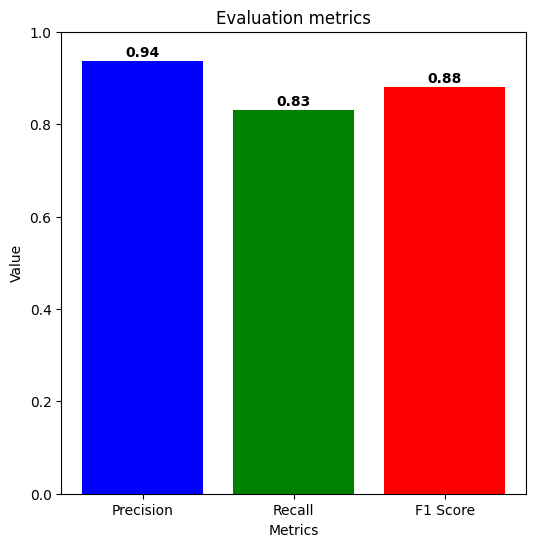

In [13]:
generate_chart(precision, recall, f1_score)